In [99]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from pulse2percept.implants import ArgusII, ProsthesisSystem, ElectrodeGrid, DiskElectrode
from pulse2percept.models import Model, ScoreboardModel, AxonMapModel
from pulse2percept.viz import plot_implant_on_axon_map

from multiprocessing import cpu_count, Pool
import parmap

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score
from skimage.transform import resize

import time
from tqdm.autonotebook import tqdm

In [100]:
DATA_PATH              = os.path.join(os.getcwd(), 'data')
FULL_ARGUSII_DATA_PATH = os.path.join(DATA_PATH, 'MNIST', 'processed')
MNIST_SUBSET_DATA_PATH = os.path.join(DATA_PATH, 'MNIST_2000_400', 'processed')

In [101]:
def load_dataset(path):
    if not os.path.exists(path):
        raise NameError("Path does not exist. Run create_dataset first")

    train_set_data   = torch.load(os.path.join(path, 'train_set_data.pt')).cuda()
    train_set_labels = torch.load(os.path.join(path, 'train_set_labels.pt')).cuda()
    test_set_data    = torch.load(os.path.join(path, 'test_set_data.pt')).cuda()
    test_set_labels  = torch.load(os.path.join(path, 'test_set_labels.pt')).cuda()

    return (TensorDataset(torch.cat([train_set_data, test_set_data]), torch.cat([train_set_labels, test_set_labels])),
            TensorDataset(train_set_data, train_set_labels),
            TensorDataset(test_set_data, test_set_labels))

In [102]:
def load_mnist_resnet_model():
    model = torchvision.models.resnet18()
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    input_size = 224

    model.load_state_dict(torch.load('./MNISTresNetModel.pth'))

    if torch.cuda.is_available():
        model.cuda()

    return model, input_size

In [103]:
model, input_size = load_mnist_resnet_model()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [201]:
torch.zeros((1, 2, 3))

tensor([[[0., 0., 0.],
         [0., 0., 0.]]])

e_num_side 25
e_radius 20


tensor([2, 2, 8, 2, 2, 2, 2, 2, 8, 7, 2, 2, 2, 8, 8, 2, 2, 8, 2, 2, 2, 2, 8, 8,
        2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 8, 2, 7, 2, 7, 2, 8, 2, 8, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 8, 2], device='cuda:0')
tensor([9., 2., 9., 8., 6., 3., 5., 6., 1., 4., 4., 2., 4., 7., 7., 3., 7., 1.,
        4., 6., 6., 8., 1., 1., 9., 2., 5., 6., 9., 3., 9., 8., 8., 8., 9., 0.,
        8., 0., 9., 0., 6., 2., 8., 3., 3., 2., 7., 2., 7., 8., 8., 7., 2., 0.,
        3., 9., 1., 2., 0., 7., 4., 0., 1., 6.])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 8, 2, 2, 8, 2, 2, 8, 8, 2,
        7, 2, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 7, 8, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2], device='cuda:0')
tensor([9., 0., 2., 4., 8., 4., 8., 0., 3., 0., 2., 5., 3., 3., 5., 2., 3., 2.,
        5., 9., 4., 1., 8., 5., 6., 5., 8., 2., 0., 6., 1., 7., 7., 6., 5., 7.,
        3., 8., 9., 2., 4., 7., 0., 9., 2., 3., 6., 6., 9., 5., 3., 2., 6., 0.,
   

tensor([2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 8, 2, 8, 8, 8, 2, 2, 2, 2, 8, 2, 2, 2,
        2, 2, 2, 2, 8, 2, 8, 2, 7, 8, 2, 8, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([9., 7., 9., 2., 5., 0., 2., 6., 1., 5., 6., 2., 4., 9., 1., 8., 5., 3.,
        4., 9., 7., 6., 8., 3., 0., 2., 3., 9., 1., 3., 1., 8., 4., 4., 2., 5.,
        0., 3., 4., 2., 8., 6., 0., 0., 5., 0., 2., 3., 9., 6., 1., 1., 7., 9.,
        3., 2., 5., 7., 4., 3., 2., 7., 7., 5.])
tensor([7, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2,
        2, 2, 8, 2, 2, 2, 2, 2, 8, 8, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2,
        8, 2, 2, 2, 2, 8, 8, 2, 8, 2, 8, 2, 2, 2, 2, 2], device='cuda:0')
tensor([4., 0., 0., 3., 6., 8., 2., 7., 7., 7., 5., 6., 1., 3., 6., 0., 9., 5.,
        2., 9., 2., 0., 6., 9., 8., 5., 1., 0., 5., 5., 9., 6., 3., 1., 7., 5.,
        1., 9., 3., 7., 0., 4., 3., 6., 3., 3., 6., 9., 1., 7., 5., 2., 4., 2.,
   

<ipython-input-202-0d210bd6e3da>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


tensor([2, 2, 8, 2, 8, 8, 2, 2, 8, 8, 8, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 8, 2, 8, 2, 8, 7, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 7, 2, 2, 8, 2,
        2, 2, 8, 7, 2, 2, 2, 2, 8, 8, 7, 2, 2, 2, 2, 2], device='cuda:0')
tensor([2., 8., 8., 4., 7., 8., 2., 4., 1., 3., 0., 8., 5., 3., 0., 7., 9., 5.,
        0., 4., 4., 3., 8., 2., 3., 7., 9., 8., 7., 4., 7., 4., 8., 8., 8., 7.,
        6., 7., 5., 1., 3., 5., 8., 8., 5., 8., 9., 0., 9., 0., 9., 2., 9., 9.,
        0., 8., 9., 5., 4., 6., 5., 6., 8., 6.])
tensor([2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 8, 8, 2,
        8, 2, 2, 2, 8, 2, 8, 2, 2, 2, 2, 2, 8, 2, 2, 8], device='cuda:0')
tensor([0., 9., 4., 4., 0., 8., 4., 4., 9., 8., 6., 7., 6., 1., 1., 5., 8., 5.,
        3., 9., 6., 4., 6., 4., 4., 0., 3., 6., 6., 7., 5., 9., 2., 9., 0., 3.,
        2., 7., 4., 0., 0., 6., 0., 3., 6., 5., 7., 5., 0., 2., 4., 5., 6., 5.,
   

tensor([2, 2, 8, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 7, 2, 2, 2, 7, 8, 2, 8, 2, 8, 2,
        2, 2, 2, 8, 8, 2, 8, 2, 2, 2, 2, 8, 2, 2, 7, 8, 8, 7, 2, 2, 2, 2, 2, 2,
        8, 2, 8, 2, 8, 7, 2, 2, 2, 2, 2, 8, 2, 2, 2, 8], device='cuda:0')
tensor([0., 0., 1., 3., 7., 7., 8., 0., 5., 9., 3., 3., 5., 8., 8., 4., 2., 9.,
        9., 5., 3., 7., 7., 2., 9., 3., 4., 6., 7., 6., 1., 6., 5., 2., 2., 1.,
        9., 2., 8., 9., 6., 4., 9., 9., 2., 8., 5., 2., 3., 4., 9., 4., 5., 1.,
        4., 3., 2., 5., 4., 1., 4., 7., 8., 5.])
tensor([8, 2, 2, 8, 2, 2, 8, 2, 2, 2, 8, 2, 2, 8, 8, 8, 2, 2, 2, 8, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 8, 2, 2, 8, 2, 2, 8, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8,
        8, 7, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8], device='cuda:0')
tensor([7., 5., 5., 9., 6., 8., 7., 4., 3., 8., 6., 0., 6., 7., 5., 5., 9., 8.,
        8., 1., 3., 4., 0., 9., 0., 9., 0., 8., 5., 7., 4., 7., 1., 0., 4., 1.,
        2., 4., 6., 8., 5., 2., 0., 6., 8., 0., 8., 4., 1., 6., 1., 4., 4., 6.,
   

<ipython-input-202-0d210bd6e3da>:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


tensor([2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8,
        8, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 8, 8, 8, 8, 2, 2, 8, 2, 2, 2, 2, 2, 8, 8], device='cuda:0')
tensor([3., 6., 4., 9., 9., 6., 7., 1., 8., 9., 0., 5., 3., 8., 8., 2., 8., 7.,
        7., 4., 5., 6., 7., 5., 8., 5., 6., 6., 2., 0., 3., 3., 9., 3., 3., 9.,
        7., 8., 8., 7., 2., 4., 4., 5., 2., 1., 0., 2., 2., 5., 7., 3., 1., 1.,
        9., 9., 1., 8., 4., 8., 5., 9., 1., 1.])
tensor([8, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 8, 8,
        2, 2, 7, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 8, 8, 2, 8, 2, 8,
        8, 2, 2, 2, 2, 8, 2, 7, 2, 8, 2, 8, 2, 2, 2, 2], device='cuda:0')
tensor([7., 8., 0., 8., 6., 6., 3., 3., 2., 9., 2., 0., 0., 0., 8., 0., 1., 6.,
        7., 3., 3., 0., 1., 2., 7., 0., 8., 1., 8., 6., 0., 0., 5., 5., 9., 9.,
        3., 6., 6., 3., 3., 0., 5., 1., 9., 1., 8., 6., 1., 9., 2., 9., 0., 7.,
   

tensor([2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7,
        8, 2, 8, 2, 2, 7, 2, 2, 2, 2, 8, 7, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8,
        2, 2, 2, 8, 8, 8, 8, 2, 2, 8, 8, 2, 8, 8, 7, 2], device='cuda:0')
tensor([9., 2., 5., 2., 8., 9., 9., 0., 2., 4., 1., 6., 1., 0., 3., 5., 9., 3.,
        8., 5., 9., 4., 2., 9., 1., 0., 8., 8., 2., 6., 7., 2., 4., 6., 1., 2.,
        9., 0., 7., 3., 6., 5., 3., 3., 9., 0., 7., 1., 3., 2., 5., 8., 1., 1.,
        9., 8., 0., 1., 2., 2., 9., 9., 8., 4.])
tensor([8, 2, 2, 2, 8, 8, 8, 2, 2, 2, 8, 2, 2, 2, 2, 8, 8, 2, 8, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 8,
        8, 2, 2, 8, 2, 8, 8, 2, 2, 8, 8, 2, 2, 8, 7, 2], device='cuda:0')
tensor([7., 2., 5., 6., 1., 6., 1., 0., 3., 7., 1., 9., 2., 5., 3., 0., 9., 9.,
        7., 6., 9., 7., 4., 6., 8., 2., 2., 0., 7., 7., 8., 5., 3., 7., 1., 5.,
        3., 4., 3., 0., 3., 7., 8., 0., 6., 3., 4., 8., 2., 8., 6., 1., 3., 1.,
   

tensor([2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 2,
        2, 2, 8, 7, 8, 2, 2, 2, 7, 2, 2, 2, 2, 2, 7, 8, 2, 2, 8, 2, 2, 8, 2, 8,
        8, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 7, 2, 2, 2, 8], device='cuda:0')
tensor([7., 6., 8., 3., 9., 3., 4., 1., 3., 8., 2., 3., 0., 0., 7., 6., 9., 5.,
        8., 3., 4., 6., 8., 2., 0., 2., 2., 6., 7., 9., 5., 4., 9., 5., 3., 0.,
        6., 0., 4., 9., 3., 7., 8., 4., 4., 1., 6., 1., 4., 7., 4., 2., 0., 1.,
        6., 9., 3., 3., 7., 1., 6., 0., 3., 7.])
tensor([2, 8, 2, 8, 8, 2, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 8, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 8, 2, 7, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 8, 2, 2,
        7, 2, 2, 2, 2, 8, 2, 2, 8, 7, 2, 2, 8, 2, 7, 2], device='cuda:0')
tensor([3., 9., 0., 7., 7., 8., 6., 1., 8., 3., 4., 3., 0., 0., 8., 8., 3., 8.,
        1., 2., 0., 4., 0., 6., 9., 5., 4., 7., 5., 7., 7., 7., 3., 6., 6., 6.,
        2., 6., 3., 1., 2., 0., 2., 0., 5., 9., 7., 8., 4., 9., 2., 5., 6., 1.,
   

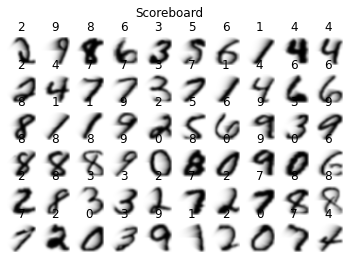

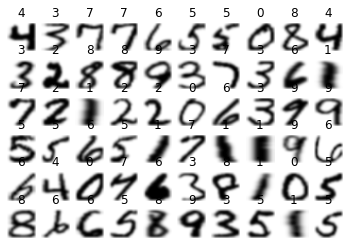

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

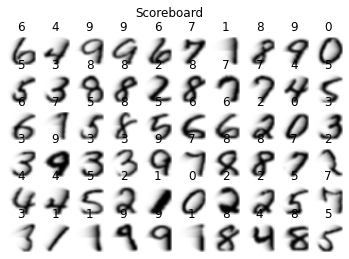

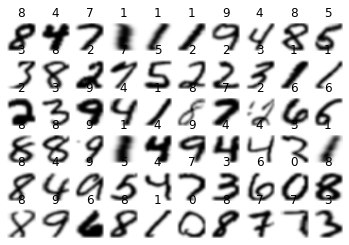

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [202]:
# e_num_sides = [  5,   8,  10, 15, 25]
# e_radius_lb = [ 10,  10,  10, 10, 10]
# e_radius_ub = [400, 400, 400, 90, 60]

e_num_sides = [25]
e_radius_lb = [20]
e_radius_ub = [30]
spacing     = None
total_area  = 4000

e_num_sides_acc = np.zeros((len(e_num_sides), (max(e_radius_ub) - min(e_radius_lb))//10 + 1, 2))
e_radius_acc    = np.zeros(((max(e_radius_ub) - min(e_radius_lb))//10 + 1, len(e_num_sides), 2))


for ens_idx, e_num_side in enumerate(e_num_sides):
    print("e_num_side", e_num_side)
    for er_idx, e_radius in enumerate(range(e_radius_lb[ens_idx], e_radius_ub[ens_idx] + 1, 10)):
        print("e_radius", e_radius)
        implant_name = 'e_num_side='+str(e_num_side)+'-e_radius='+str(e_radius)+ \
                       '-spacing='+str(spacing)+'-total_area='+str(total_area)

        axon_dataset  , _, _ = load_dataset(os.path.join(MNIST_SUBSET_DATA_PATH, 'AxonMapModel-'+implant_name))
        sboard_dataset, _, _ = load_dataset(os.path.join(MNIST_SUBSET_DATA_PATH, 'ScoreboardModel-'+implant_name))

        axon_train_data = torch.zeros((len(axon_dataset), 28, 28))
        for i, (X, _) in enumerate(axon_dataset):
            axon_train_data[i, :, :] = X
        sboard_train_data = torch.zeros((len(sboard_dataset), 28, 28))
        for i,(X, _) in enumerate(axon_dataset):
            sboard_train_data[i, :, :] = X
        
        axon_norm   = transforms.Normalize((axon_train_data.mean()/255,), (axon_train_data.std()/255,))
        sboard_norm = transforms.Normalize((sboard_train_data.mean()/255,), (sboard_train_data.std()/255,))

        axon_loader   = torch.utils.data.DataLoader(axon_dataset,   batch_size=64, shuffle=True)
        sboard_loader = torch.utils.data.DataLoader(sboard_dataset, batch_size=64, shuffle=True)

        axon_accuracy   = []
        sboard_accuracy = []
        batch_number    = len(axon_loader)

        model.eval()
        with torch.no_grad():
            for i, (ax_data, sc_data) in tqdm(enumerate(zip(axon_loader, sboard_loader)), total=batch_number):
                a_X = torch.Tensor(
                        np.expand_dims(
                            axon_norm(
                                torch.Tensor(
                                    resize(ax_data[0].cpu(),
                                           (ax_data[0].shape[0], input_size, input_size))
                                            )
                                     ),
                            1         )
                                  ).to(device)
                a_y = ax_data[1].to(device)
                s_X = torch.Tensor(
                        np.expand_dims(
                            sboard_norm(
                                torch.Tensor(
                                    resize(sc_data[0].cpu(),
                                           (sc_data[0].shape[0], input_size, input_size))
                                            )
                                       ),
                            1         )
                                  ).to(device)
                s_y = sc_data[1].to(device)
                fig = plt.figure()
                num_of_images = 60
                if i==0:
                    for index in range(1, num_of_images + 1):
                        plt.subplot(6, 10, index)
                        plt.axis('off')
                        plt.imshow(a_X[index].cpu().numpy().squeeze(), cmap='gray_r')
                        plt.title(int(a_y[index].cpu()))
                    fig.suptitle('Axon')
                    plt.figure()
                    for index in range(1, num_of_images + 1):
                        plt.subplot(6, 10, index)
                        plt.axis('off')
                        plt.imshow(s_X[index].cpu().numpy().squeeze(), cmap='gray_r')
                        plt.title(int(s_y[index].cpu()))
                    fig.suptitle('Scoreboard')
                a_outputs = model(a_X) # this get's the prediction from the network
                s_outputs = model(s_X) # this get's the prediction from the network
                a_predicted_classes = torch.max(a_outputs, 1)[1] # get class from network's prediction
                print(a_predicted_classes)
                s_predicted_classes = torch.max(s_outputs, 1)[1] # get class from network's prediction
                print(a_y.cpu())
                axon_accuracy.append(accuracy_score(a_y.cpu()  , a_predicted_classes.cpu()))
                sboard_accuracy.append(accuracy_score(s_y.cpu(), s_predicted_classes.cpu()))
            e_num_sides_acc[ens_idx, er_idx, :] =[sum(axon_accuracy)/batch_number,
                                                  sum(sboard_accuracy)/batch_number]
            e_radius_acc[er_idx, ens_idx, :]    =[sum(axon_accuracy)/batch_number,
                                                  sum(sboard_accuracy)/batch_number]

In [203]:
axon_accuracy

[0.109375,
 0.078125,
 0.203125,
 0.078125,
 0.125,
 0.171875,
 0.09375,
 0.03125,
 0.109375,
 0.140625,
 0.109375,
 0.0625,
 0.0625,
 0.09375,
 0.09375,
 0.125,
 0.15625,
 0.09375,
 0.046875,
 0.140625,
 0.125,
 0.109375,
 0.140625,
 0.078125,
 0.109375,
 0.03125,
 0.125,
 0.140625,
 0.125,
 0.078125,
 0.0625,
 0.125,
 0.09375,
 0.109375,
 0.125,
 0.046875,
 0.109375,
 0.09375]

In [166]:
mnist       = datasets.MNIST(download=True, train=True, root=".").data.float()

transform   = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,))])
testset     = datasets.MNIST('./data', download=True, train=False, transform=transform)

testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)

loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = optim.Adadelta(model.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val_batches = len(testloader)

# ----------------- VALIDATION  ----------------- 
val_losses = 0
accuracy = []
    
# set model to evaluating (testing)
model.eval()
with torch.no_grad():
    for i, data in enumerate(testloader):
        X, y = data[0].to(device), data[1].to(device)
        outputs = model(X) # this get's the prediction from the network
        val_losses += loss_function(outputs, y)

        predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
        accuracy.append(accuracy_score(y.cpu(), predicted_classes.cpu()))
print(f"\taccuracy: {sum(accuracy)/val_batches:.4f}")

C:\Users\el16077\anaconda3\envs\emhealth\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


	accuracy: 0.9706


In [110]:
np.save('e_num_sides_acc.npy', e_num_sides_acc)
np.save('e_radius_acc.npy', e_radius_acc)

In [114]:
%matplotlib inline

In [123]:
e_radius_acc.shape

(40, 5, 2)

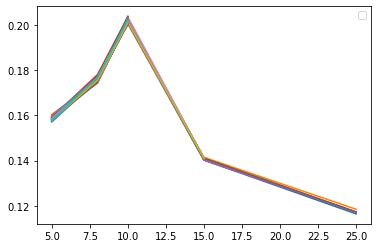

In [141]:
for i in range(e_radius_acc.shape[0]):
    plt.plot(np.array([5, 8, 10, 15, 25])[e_radius_acc[i, :, 0] > 0], e_radius_acc[i, e_radius_acc[i, :, 0] > 0, 0])
plt.legend()

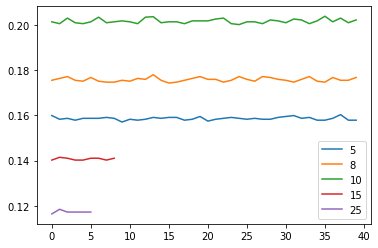

In [142]:
for i in range(e_num_sides_acc.shape[0]):
    plt.plot(e_num_sides_acc[i, e_num_sides_acc[i, :, 0] > 0, 0], label=e_num_sides[i])
plt.legend()

In [149]:
implant_name = 'e_num_side='+str(10)+'-e_radius='+str(20)+ \
               '-spacing='+str(None)+'-total_area='+str(4000)

axon_dataset  , _, _ = load_dataset(os.path.join(MNIST_SUBSET_DATA_PATH, 'AxonMapModel-'+implant_name))
sboard_dataset, _, _ = load_dataset(os.path.join(MNIST_SUBSET_DATA_PATH, 'ScoreboardModel-'+implant_name))

axon_loader   = torch.utils.data.DataLoader(axon_dataset,   batch_size=64, shuffle=True)
sboard_loader = torch.utils.data.DataLoader(sboard_dataset, batch_size=64, shuffle=True)

In [152]:
dataiter = iter(axon_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 28, 28])
torch.Size([64])


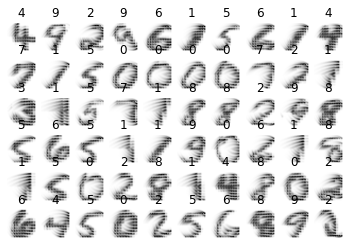

In [153]:
fig = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')
    plt.title(int(labels[index].cpu()))